In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC, SVC
from scipy import stats
from pathlib import Path, PureWindowsPath
import os
from tqdm import tqdm

In [2]:
def extract_dataset_info(data_path):
    # extract information from train.txt
    f = open(os.path.join(data_path, "train.txt"), "r")
    contents_train = f.readlines()
    label_classes, label_train_list, image_train_list = [], [], []
    for sample in contents_train:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        if label not in label_classes:
            label_classes.append(label)
        label_train_list.append(sample[0])
        image_train_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))
    print('Classes: {}'.format(label_classes))

    # extract information from test.txt
    f = open(os.path.join(data_path, "test.txt"), "r")
    contents_test = f.readlines()
    label_test_list, image_test_list = [], []
    for sample in contents_test:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        label_test_list.append(label)
        image_test_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))  # you can directly use img_path if you run in Windows

    return label_classes, label_train_list, image_train_list, label_test_list, image_test_list


def get_scene_classification_data(data_dir):
    label_classes, label_train_list, image_train_list, label_test_list, image_test_list = \
        extract_dataset_info(data_dir)

    image_train, label_train, image_test, label_test = [], [], [], []
    for i, img_path in enumerate(image_train_list):
        image_train.append(cv2.imread(img_path, 0))
        label_train.append(label_classes.index(label_train_list[i]))
    for i, img_path in enumerate(image_test_list):
        image_test.append(cv2.imread(img_path, 0))
        label_test.append(label_classes.index(label_test_list[i]))

    label_train = np.array(label_train).reshape((-1, 1))
    label_test = np.array(label_test).reshape((-1, 1))

    return image_train, label_train, image_test, label_test, label_classes


def visualize_confusion_matrix(confusion, accuracy, label_classes):
    plt.title("accuracy = {:.3f}".format(accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    plt.show()


# Change work_dir if the data is put in a different directory
work_dir = '/content/drive/MyDrive/3rd Semester Stuff/Computer Vision/hw4/'

# Data preparation
image_train, label_train, image_test, label_test, label_classes = get_scene_classification_data(
    work_dir + 'scene_classification_data')


Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']


In [3]:
def get_tiny_image(img, tiny_size):
    # To do
    resized_img = cv2.resize(img, tiny_size, interpolation = cv2.INTER_LINEAR)
    vector = resized_img.flatten()
    feature = (vector - np.mean(vector)) / np.std(vector)

    return feature.reshape(1, -1).T


# Tiny + KNN
feature_train = np.hstack([get_tiny_image(img, (16, 16)) for img in image_train]).T  # (1500, 256)
feature_test = np.hstack([get_tiny_image(img, (16, 16)) for img in image_test]).T  # (1500, 256)
n_neighbors = 5

In [4]:
def predict_knn(feature_train, label_train, feature_test, n_neighbors):
    pred_test = np.zeros((feature_test.shape[0]), dtype=int)
    for i, test in enumerate(feature_test):
        distances = np.linalg.norm(feature_train - test, axis=1)
        sorted_indices = np.argsort(distances)
        lowest_k_indices = sorted_indices[:n_neighbors]
        labels = label_train[lowest_k_indices].flatten()
        pred_test[i] = np.argmax(np.bincount(labels))

    return pred_test


pred_test = predict_knn(feature_train, label_train, feature_test, n_neighbors)  # (1500, 1)

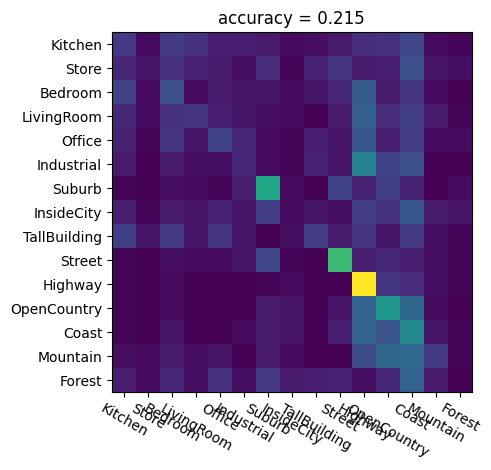

In [5]:
def compute_confusion_matrix_and_accuracy(pred, label, n_classes):
    confusion = np.zeros((n_classes, n_classes))
    for p, l in zip(pred, label.flatten()):
        confusion[l,p] += 1

    accuracy = np.trace(confusion)/label.shape[0]

    return confusion, accuracy


confusion, accuracy = compute_confusion_matrix_and_accuracy(pred_test, label_test, len(label_classes))
visualize_confusion_matrix(confusion, accuracy, label_classes)

In [7]:
def compute_dsift(img, stride, size):
    dsift = []
    kp = []

    for i in range(0, img.shape[0] - size + 1, stride):
        for j in range(0, img.shape[1] - size + 1, stride):
            kp.append(cv2.KeyPoint(j, i, size))

    sift = cv2.SIFT.create()
    keypoints, dsift= sift.compute(img, kp)

    return np.array(dsift)


# Bag-of-words + KNN / SVM

# Bag-of-words
# 1. extract dense sift features
stride, keypoint_size = 16, 16
dsift_train = [compute_dsift(image, stride, keypoint_size) for image in tqdm(
    image_train, 'Extracting dense SIFT features for images from train set')]  # a list of (n, 128)
dsift_test = [compute_dsift(image, stride, keypoint_size) for image in tqdm(
    image_test, 'Extracting dense SIFT features for images from test set')]  # a list of (n, 128)


Extracting dense SIFT features for images from train set:   0%|          | 0/1500 [00:00<?, ?it/s]
Extracting dense SIFT features for images from train set:   0%|          | 2/1500 [00:00<01:27, 17.14it/s]
Extracting dense SIFT features for images from train set:   0%|          | 4/1500 [00:00<01:31, 16.41it/s]
Extracting dense SIFT features for images from train set:   0%|          | 6/1500 [00:00<01:33, 16.04it/s]
Extracting dense SIFT features for images from train set:   1%|          | 8/1500 [00:00<01:35, 15.57it/s]
Extracting dense SIFT features for images from train set:   1%|          | 10/1500 [00:00<01:35, 15.59it/s]
Extracting dense SIFT features for images from train set:   1%|          | 12/1500 [00:00<01:34, 15.80it/s]
Extracting dense SIFT features for images from train set:   1%|          | 14/1500 [00:00<01:31, 16.16it/s]
Extracting dense SIFT features for images from train set:   1%|          | 16/1500 [00:00<01:30, 16.35it/s]
Extracting dense SIFT features for image

In [21]:
def build_visual_dictionary(features, dict_size):
    Kmean = KMeans(n_clusters=dict_size, n_init=10)
    Kmean.fit(features)
    vocab = Kmean.cluster_centers_
    return vocab

# 2. build dictionary from train data
dic_size = 100
vocab = build_visual_dictionary(np.vstack(dsift_train), dic_size)

file_path = '/content/drive/MyDrive/3rd Semester Stuff/Computer Vision/hw4/visual_dictionary.txt'

# Save the visual dictionary to the file
np.savetxt(file_path, vocab)

In [22]:
def compute_bow(dsift, vocab):

    bow_feature = np.zeros((vocab.shape[0],1))
    for feature in dsift:
        distances = np.linalg.norm(vocab - feature, axis=1)
        bow_feature[np.argmin(distances),0] += 1

    bow_feature = (bow_feature - np.mean(bow_feature, axis=0))/np.std(bow_feature, axis=0)
    return bow_feature


# 3. extract bag-of-words features
#vocab = np.loadtxt('/content/drive/MyDrive/3rd Semester Stuff/Computer Vision/hw4/visual_dictionary.txt')
feature_train = np.hstack([compute_bow(dsift, vocab) for dsift in dsift_train]).T  # (n_train, dic_size)
feature_test = np.hstack([compute_bow(dsift, vocab) for dsift in dsift_test]).T  # (n_test, dic_size)

Extracting dense SIFT features for images from test set:  44%|████▎     | 654/1500 [1:12:54<1:34:18,  6.69s/it]


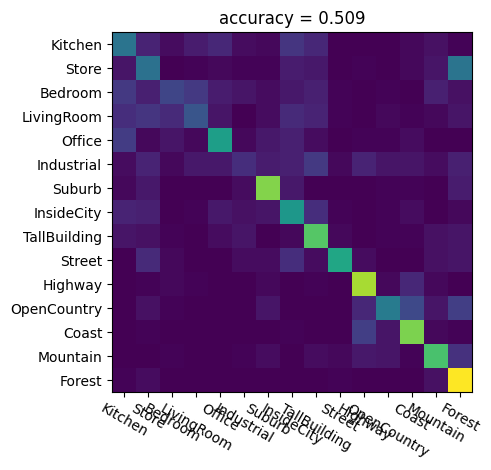

In [27]:
# KNN
n_neighbors = 7
pred_test = predict_knn(feature_train, label_train, feature_test, n_neighbors)  # (1500, 1)
confusion, accuracy = compute_confusion_matrix_and_accuracy(pred_test, label_test, len(label_classes))
visualize_confusion_matrix(confusion, accuracy, label_classes)

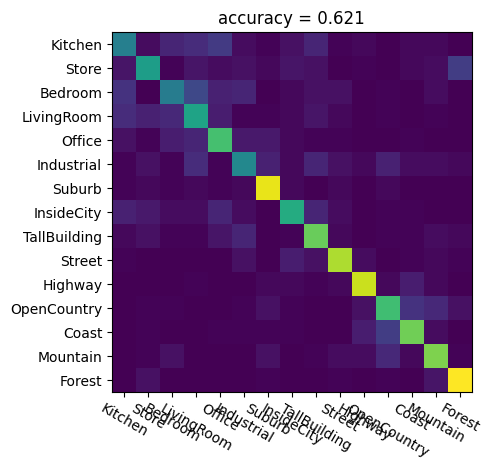

In [28]:
def predict_svm(feature_train, label_train, feature_test, n_classes):
    predicted_labels = []

    for i in range(n_classes):
        temp_label = (label_train == i)
        clf = SVC(probability=True)
        clf.fit(feature_train, temp_label.flatten())
        confidence = clf.predict_proba(feature_test)[:, 1]
        predicted_labels.append(confidence)

    pred_test = np.argmax(predicted_labels, axis=0)
    return pred_test




# SVM
pred_test = predict_svm(feature_train, label_train, feature_test, len(label_classes))  # (1500, 1)
confusion, accuracy = compute_confusion_matrix_and_accuracy(pred_test, label_test, len(label_classes))
visualize_confusion_matrix(confusion, accuracy, label_classes)